In [1]:
import numpy as np

import dataset
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset
#from torch.nn.utils.rnn import pack_padded_sequence
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "bert-base-uncased"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.2.crossattention.self.value.bias', 'bert.encoder.layer.9.crossattention.output.dense.bias', 'bert.encoder.layer.2.crossattention.self.key.weight', 'bert.encoder.layer.2.crossattention.output.dense.weight', 'bert.encoder

In [3]:
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer =  AutoTokenizer.from_pretrained('bert-base-uncased')

In [4]:
model.config.eos_token_id = 102
model.config.pad_token_id = model.config.eos_token_id
model.config.bos_token_id = 101

In [5]:
data_location = "../dataset"

In [6]:
#define the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
#    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [7]:
#testing the dataset class
flickr_dataset =  dataset.FlickrDatasetTransformer(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Token: tensor([[ 101, 1037, 2775, 1999, 1037, 5061, 4377, 2003, 8218, 2039, 1037, 2275,
         1997, 5108, 1999, 2019, 4443, 2126, 1012,  102]])
Sentence:
['[CLS] a child in a pink dress is climbing up a set of stairs in an entry way. [SEP]']


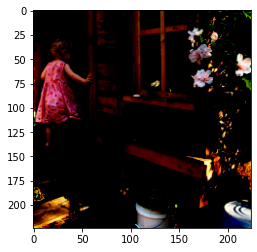

In [8]:
img, caps = flickr_dataset[0]
plt.imshow(img.numpy()[0].transpose((1,2,0)))
print("Token:",caps)
print("Sentence:")
print(tokenizer.batch_decode(caps))

In [9]:
from torch.nn.utils.rnn import pad_sequence
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0] for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1].squeeze(0) for item in batch]

        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs, targets

In [10]:
BATCH_SIZE = 4


#token to represent the padding
pad_idx = model.config.pad_token_id




train_loader = DataLoader(
    dataset=flickr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [ ]:
LEARNING_RATE = 1e-5
EPOCHS = 10


training_loss = []
valid_loss = []
#valid_bleu1 = []
#valid_bleu4 = []

best_valid_loss = 100 # large number for base iteration

terminate_count = 5 # after 5 continuous worse validation loss, terminate training

if __name__ == "__main__": 
    device = torch.device("cuda")
    print(torch.cuda.memory_allocated(device))
    # to cuda device
    model = model.to(device)
    print(torch.cuda.memory_allocated(device))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for i in range(EPOCHS):
        for idx, (imgs, caps) in enumerate(tqdm(train_loader)):

            optimizer.zero_grad()
            
            
            imgs, caps = imgs.to(device), caps.to(device)
            
            out = model(imgs, caps)
            loss = criterion(out[0].transpose(2,1), caps)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())


            if (idx+1)%300 == 0:
                print("loss: {:.5f}".format(loss.item()))

        # evaluate on validation set
        



In [ ]:
img, caps = flickr_dataset[50]
plt.imshow(img.numpy()[0].transpose((1,2,0)))
print("Token:",caps)
print("Sentence:")
print(tokenizer.batch_decode(caps))

In [ ]:
model.generate(imgs)

In [ ]:
out = model(imgs, torch.Tensor([tokenizer('Caption this Image')['input_ids']]*4).long().to(device))

In [ ]:
criterion(model.generate(imgs), out[0].max(2)[1].int())

In [ ]:
tokenizer.batch_decode(out[0].max(2)[1])

In [ ]:
model()